# Connecting to MIMIC

I took the following from https://github.com/MIT-LCP/mimic-code/blob/main/mimic-iii/tutorials/cohort-selection.ipynb

What I have done was download the data to my local home server (it was very slow, took about 5 hours). I then used the repository I linked above and converted the csv files into a postgres database, which I can now access locally!

The below works on my machine when running the database:

In [45]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2

# below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

%matplotlib inline
plt.style.use('ggplot')

# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser, password="postgres")

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'


In [46]:
query = query_schema + """
SELECT subject_id, hadm_id, icustay_id
FROM icustays
LIMIT 100
"""
df = pd.read_sql_query(query, con)
df.head(10)

/tmp/ipykernel_96504/4282104791.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, con)


,subject_id,hadm_id,icustay_id
0,268,110404,280836
1,269,106296,206613
2,270,188028,220345
3,271,173727,249196
4,272,164716,210407
5,273,158689,241507
6,274,130546,254851
7,275,129886,219649
8,276,135156,206327
9,277,171601,272866


In [47]:
query = query_schema + """
SELECT itemid, label
FROM d_items
ORDER BY itemid;
"""

itemids = pd.read_sql_query(query, con)
itemids.head(100)

/tmp/ipykernel_96504/3884238648.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  itemids = pd.read_sql_query(query, con)


,itemid,label
0,1,% Inspir. Time
1,2,ABI (L)
2,3,ABI (R)
3,4,ABI Ankle BP [Right]
4,5,ABI Brachial BP [Right]
...,...,...
95,117,Catheter Insert Date
96,118,Cerv Collar Status
97,119,Cervical Collar Type
98,121,Chest PT [Right]


In [48]:
query = query_schema + """
SELECT itemid, label
FROM d_items
WHERE LOWER(label) LIKE '%white%'
ORDER BY itemid;
"""

white_blood_cell_items = pd.read_sql_query(query, con)
white_blood_cell_items

/tmp/ipykernel_96504/500777219.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  white_blood_cell_items = pd.read_sql_query(query, con)


,itemid,label
0,3834,WhiteBloodC 4.0-11.0


# 5.1 "Surprising Distribution of Heart Rates"

In [49]:
heart_itemids = itemids[itemids['label'].str.contains("heart", case=False, na=False)]
# print(heart_itemids)

## Figure 2 Recreation

In [50]:
# looks like we want to include 211, 220045 ... and potentially 5972 (fetal heart rate)

In [51]:
# heart rates
query = query_schema + """
SELECT
    c.subject_id,
    c.hadm_id,
    c.icustay_id,
    c.charttime,
    c.value AS heart_rate,
    EXTRACT(YEAR FROM AGE(c.charttime, p.dob)) AS age -- Adjusted to prevent negative ages
FROM
    chartevents c
JOIN
    patients p ON c.subject_id = p.subject_id
WHERE
    c.itemid IN (220045, 211, 5972)  -- Include the specified item IDs
    AND c.value IS NOT NULL
ORDER BY
    c.charttime;

"""

heart = pd.read_sql_query(query, con)
heart.head(10)

/tmp/ipykernel_96504/920133899.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  heart = pd.read_sql_query(query, con)


,subject_id,hadm_id,icustay_id,charttime,heart_rate,age
0,82574,118464,202134.0,2100-06-08 00:18:00,68,56.0
1,82574,118464,202134.0,2100-06-08 01:00:00,59,56.0
2,82574,118464,202134.0,2100-06-08 02:00:00,58,56.0
3,82574,118464,202134.0,2100-06-08 02:30:00,60,56.0
4,82574,118464,202134.0,2100-06-08 02:44:00,69,56.0
5,82574,118464,202134.0,2100-06-08 02:45:00,63,56.0
6,82574,118464,202134.0,2100-06-08 03:00:00,60,56.0
7,82574,118464,202134.0,2100-06-08 03:15:00,61,56.0
8,82574,118464,202134.0,2100-06-08 03:30:00,60,56.0
9,82574,118464,202134.0,2100-06-08 04:00:00,60,56.0


In [52]:
heart.shape

(7923714, 6)

In [53]:
heart['heart_rate'] = pd.to_numeric(heart['heart_rate'], errors='coerce')

na_count = heart['heart_rate'].isnull().sum()
print("Number of NaN values in heart_rate:", na_count)

Number of NaN values in heart_rate: 0


In [54]:
mean_heart_rate = heart['heart_rate'].mean()
print("Mean Heart Rate:", mean_heart_rate)

Mean Heart Rate: 102.66196480034685


In [55]:
median_heart_rate = heart['heart_rate'].median()
print("Median Heart Rate:", median_heart_rate)

Median Heart Rate: 92.0


In [56]:
mean_age = heart['age'].mean()
print("Mean Age:", mean_age)

Mean Age: 57.427613995154296


In [57]:
median_age = heart['age'].median()
print("Median Age:", median_age)

Median Age: 60.0


In [58]:
min_age = heart['age'].min()
print("Min Age:", min_age)

Min Age: 0.0


In [59]:
max_age = heart['age'].max()
print("Max Age:", max_age)

Max Age: 310.0


Can we recreate figure 2 from section 5.1 now?

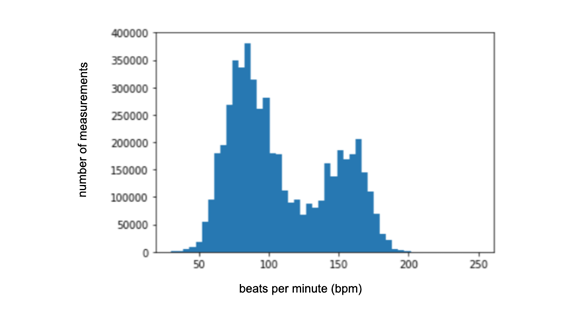

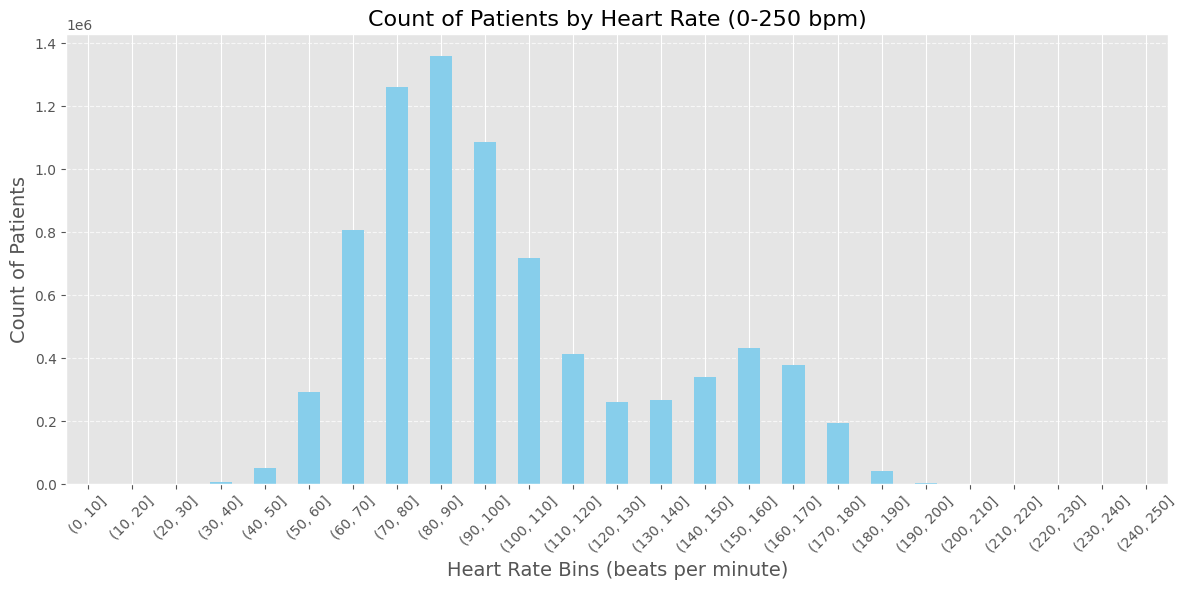

In [60]:
import matplotlib.pyplot as plt

heart = heart[(heart['heart_rate'] >= 0) & (heart['heart_rate'] <= 250)]

# Create bins for heart rate intervals (0-10, 10-20, ..., 240-250) I think this is what the image above is doing? 
bins = range(0, 260, 10)  # Bins from 0 to 250 in increments of 10
heart['heart_rate_bins'] = pd.cut(heart['heart_rate'], bins=bins)

# Count number of patients seen in each bin
heart_rate_histogram = heart['heart_rate_bins'].value_counts().sort_index()

plt.figure(figsize=(12, 6))  # Set the figure size
heart_rate_histogram.plot(kind='bar', color='skyblue')  # Bar plot
plt.xlabel('Heart Rate Bins (beats per minute)', fontsize=14)  # Label for x-axis
plt.ylabel('Count of Patients', fontsize=14)  # Label for y-axis
plt.title('Count of Patients by Heart Rate (0-250 bpm)', fontsize=16)  # Title of the chart

plt.xticks(rotation=45) 

plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.tight_layout()  
plt.show() 

Looks like we sort of have figure 2. I still want to confirm this with David.. the peaks line up, but the only thing that seems to be off is the total number of records. We max out around 1.4 million, while the figure 2 from the paper maxes out around 4 million. 

## Figure 3 Recreation

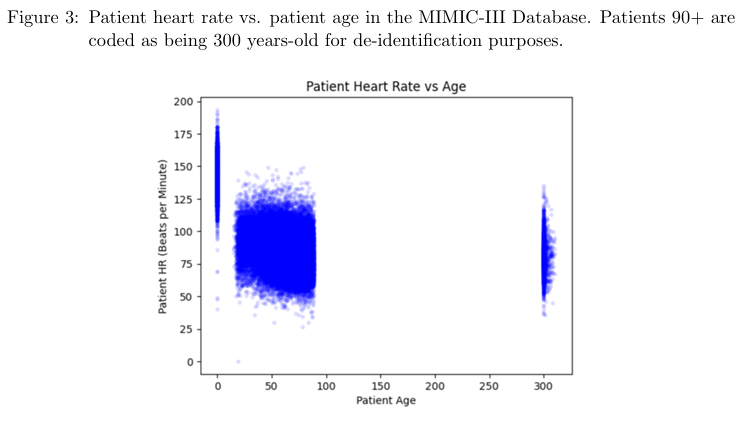

The purpose of this visual is two-fold (as described by the paper)
1. The difference in physiology of older humans and newborns is seen by the much higher heart rates seen around age 0
2. The giant gap in age from ~90 to 300. Why is this? The paper explains that all patients older than 90 are grouped together in a 300+ bin to avoid making it obvious who a person is based on their rare age

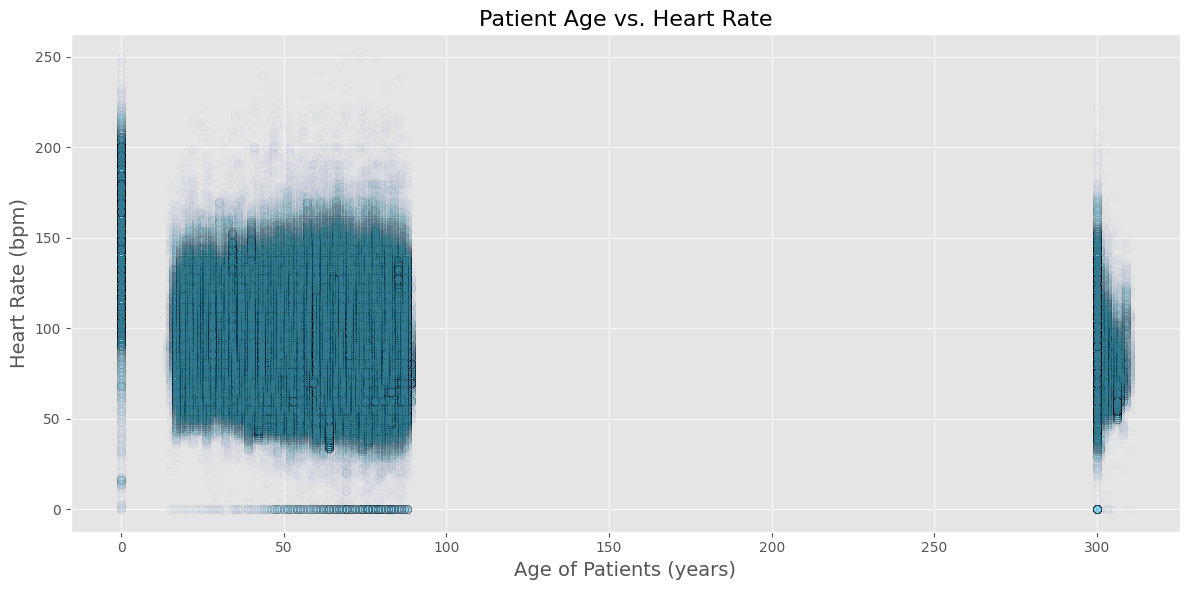

In [61]:
heart = heart[(heart['heart_rate'] >= 0) & (heart['heart_rate'] <= 250)]

plt.figure(figsize=(12, 6)) 

# Adjusting the alpha value for transparency; set lower value for more transparency
plt.scatter(heart['age'], heart['heart_rate'], alpha=0.01, color='skyblue', edgecolor='black')  

plt.xlabel('Age of Patients (years)', fontsize=14) 
plt.ylabel('Heart Rate (bpm)', fontsize=14)  
plt.title('Patient Age vs. Heart Rate', fontsize=16)  

plt.grid(alpha=0.7)  

plt.tight_layout()  
plt.show()  

Looks pretty close, don't you think? The key here is adjusting the alpha to make the dots really transparent since there is so much data that needs to fit on a single line. Not sure what is going on with the horizontal line there at the bottom.. maybe we should exclude all heart rates of 0 and chalk that up to improper measurements?

# 5.2 "Inconsistent Timestamps"

In [62]:
# get all ICU stays with their associated hospital admission/discharge times
query = """
SELECT 
    i.subject_id,
    i.hadm_id,
    i.icustay_id,
    a.admittime AS hospital_admittime,
    i.intime AS icu_intime,
    i.outtime AS icu_outtime,
    a.dischtime AS hospital_dischtime,
    -- Check if ICU intime is before hospital admission
    CASE WHEN i.intime < a.admittime THEN 1 ELSE 0 END AS icu_before_hosp_admit,
    -- Check if ICU outtime is after hospital discharge
    CASE WHEN i.outtime > a.dischtime THEN 1 ELSE 0 END AS icu_after_hosp_discharge,
    -- Calculate time differences for cases where order is wrong
    EXTRACT(EPOCH FROM (a.admittime - i.intime))/60 AS minutes_icu_before_hosp,
    EXTRACT(EPOCH FROM (i.outtime - a.dischtime))/60 AS minutes_icu_after_hosp
FROM 
    icustays i
JOIN 
    admissions a ON i.hadm_id = a.hadm_id
"""

timestamp_data = pd.read_sql_query(query, con)

/tmp/ipykernel_96504/265873069.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  timestamp_data = pd.read_sql_query(query, con)


In [63]:
# Calculate the statistics mentioned in the text
total_stays = len(timestamp_data)
print(f"Total ICU stays examined: {total_stays:,}")

# Calculate stays with all timestamps in correct order
correct_order = timestamp_data[
    (timestamp_data['icu_intime'] >= timestamp_data['hospital_admittime']) &
    (timestamp_data['icu_outtime'] <= timestamp_data['hospital_dischtime'])
]
correct_percentage = len(correct_order) / total_stays * 100
print(f"Percentage with correct chronological order: {correct_percentage:.0f}%")

# Calculate stays with at least one inconsistency
inconsistent_stays = timestamp_data[
    (timestamp_data['icu_intime'] < timestamp_data['hospital_admittime']) |
    (timestamp_data['icu_outtime'] > timestamp_data['hospital_dischtime'])
]
print(f"Stays with at least one inconsistency: {len(inconsistent_stays):,}")

# Cases where ICU intime is before hospital admission
icu_before_hosp = timestamp_data[timestamp_data['icu_intime'] < timestamp_data['hospital_admittime']]
print(f"ICU intime before hospital admission: {len(icu_before_hosp):,}")

# Cases where ICU outtime is after hospital discharge
icu_after_hosp = timestamp_data[timestamp_data['icu_outtime'] > timestamp_data['hospital_dischtime']]
print(f"ICU outtime after hospital discharge: {len(icu_after_hosp):,}")

# Cases where outtime and dischtime are within 10 minutes
within_10_min = icu_after_hosp[
    (icu_after_hosp['minutes_icu_after_hosp'] <= 10) & 
    (icu_after_hosp['minutes_icu_after_hosp'] >= 0)
]
print(f"ICU outtime after discharge but within 10 minutes: {len(within_10_min):,}")

# Cases where the difference is within 6 hours (360 minutes)
within_6_hours = icu_after_hosp[
    (icu_after_hosp['minutes_icu_after_hosp'] <= 360) & 
    (icu_after_hosp['minutes_icu_after_hosp'] >= 0)
]
percentage_within_6_hours = len(within_6_hours) / len(icu_after_hosp) * 100
print(f"Percentage of ICU-after-hospital cases within 6 hours: {percentage_within_6_hours:.0f}%")

Total ICU stays examined: 61,532
Percentage with correct chronological order: 80%
Stays with at least one inconsistency: 12,338
ICU intime before hospital admission: 486
ICU outtime after hospital discharge: 11,886
ICU outtime after discharge but within 10 minutes: 2,407
Percentage of ICU-after-hospital cases within 6 hours: 90%


All align so far with what was mentioned. 

# 5.3 "Lab Values Vary by Time of Day"

In [80]:
# Query to get WBC measurements with timestamps and flag for abnormal values
query = """
SELECT 
    l.subject_id,
    l.hadm_id,
    l.charttime,
    EXTRACT(HOUR FROM l.charttime) AS hour_of_day,
    l.valuenum AS wbc_value,  -- In K/µL (4.5–11.0 is normal)
    CASE 
        WHEN l.valuenum BETWEEN 4.5 AND 11.0 THEN 0  -- Normal
        ELSE 1                                       -- Abnormal
    END AS is_abnormal
FROM 
    labevents l
WHERE 
    l.itemid IN (51301)  -- ONLY total WBC counts
    AND l.valuenum IS NOT NULL
    AND l.valuenum > 0  -- Exclude invalid values.. should we do this?
"""

wbc_data = pd.read_sql_query(query, con)

/tmp/ipykernel_96504/2025895643.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  wbc_data = pd.read_sql_query(query, con)


In [81]:
wbc_data.head()

,subject_id,hadm_id,charttime,hour_of_day,wbc_value,is_abnormal
0,3,NaN,2101-10-14 03:00:00,3.0,9.9,0
1,3,145834.0,2101-10-23 03:45:00,3.0,12.5,1
2,3,145834.0,2101-10-20 19:26:00,19.0,11.3,1
3,3,145834.0,2101-10-20 19:59:00,19.0,19.1,1
4,3,145834.0,2101-10-20 16:40:00,16.0,12.7,1


In [82]:
wbc_data['wbc_value'].mean()

np.float64(10.504306641870347)

## Figure 5 Recreation

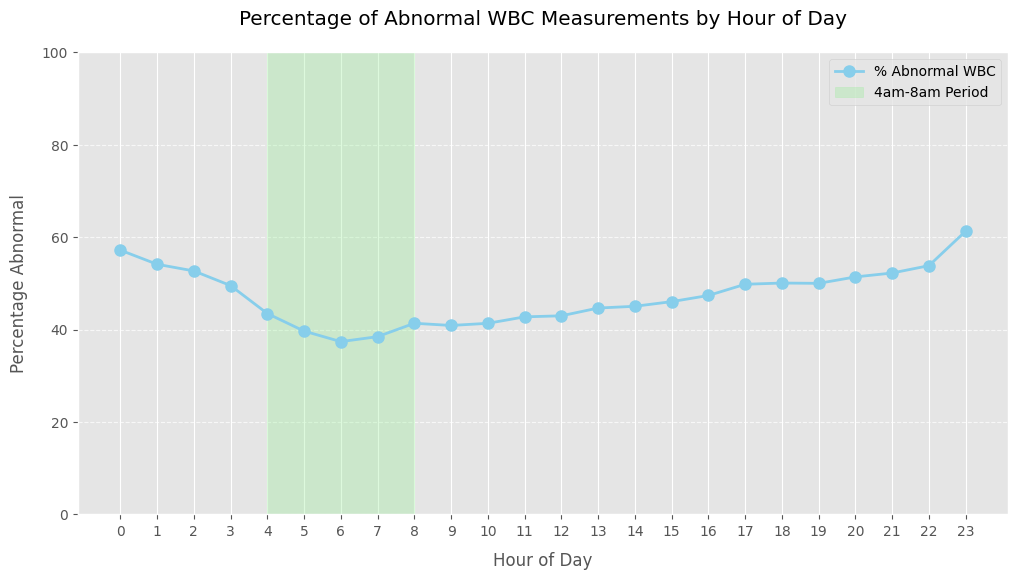

Total WBC measurements: 752,800
Overall percentage abnormal: 45.4%


In [83]:
hourly_stats = wbc_data.groupby('hour_of_day').agg(
    total_measurements=('wbc_value', 'count'),
    abnormal_measurements=('is_abnormal', 'sum')
).reset_index()

# Calculate percentage abnormal per hour
hourly_stats['pct_abnormal'] = (hourly_stats['abnormal_measurements'] / 
                                hourly_stats['total_measurements']) * 100

hourly_stats = hourly_stats.sort_values('hour_of_day')

# Plot the results as a line chart
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
line = plt.plot(hourly_stats['hour_of_day'], 
                hourly_stats['pct_abnormal'], 
                color='skyblue',
                marker='o',
                linewidth=2,
                markersize=8,
                label='% Abnormal WBC')

# Highlight the 4am-8am period with a shaded region
plt.axvspan(4, 8, color='lightgreen', alpha=0.3, label='4am-8am Period')

plt.title('Percentage of Abnormal WBC Measurements by Hour of Day', pad=20)
plt.xlabel('Hour of Day', labelpad=10)
plt.ylabel('Percentage Abnormal', labelpad=10)
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 100)  # Percentage scale
plt.legend(loc='upper right')

plt.show()

# Print some summary statistics
print(f"Total WBC measurements: {len(wbc_data):,}")
print(f"Overall percentage abnormal: {wbc_data['is_abnormal'].mean()*100:.1f}%")

This looks pretty close to me.. maybe there is an itemid that gets the values closer? You can see that the most "normal" ranges for white blood cell counts appear between 4 and 8.

# 5.4 "Multiple Copies of Provider Notes"

In [86]:
# Query to extract all we would ever want to know about duplicate provider notes
query = """
WITH note_stats AS (
    SELECT 
        subject_id,
        hadm_id,
        charttime,
        category,
        description,
        COUNT(*) AS total_versions,
        COUNT(DISTINCT text) AS unique_text_versions,
        MIN(storetime) AS first_storetime,
        MAX(storetime) AS latest_storetime
    FROM 
        mimiciii.noteevents  
    WHERE 
        (iserror IS NULL OR iserror != '1')
        AND charttime IS NOT NULL
    GROUP BY 
        subject_id, hadm_id, charttime, category, description
)
SELECT 
    *,
    (total_versions - unique_text_versions) AS exact_duplicates,
    (total_versions - 1) AS potential_drafts
FROM 
    note_stats
ORDER BY 
    total_versions DESC;
"""

notes_df = pd.read_sql_query(query, con)

/tmp/ipykernel_96504/3453081469.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  notes_df = pd.read_sql_query(query, con)


/tmp/ipykernel_96504/1257382070.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  notes_df = pd.read_sql_query(query, con)


=== Duplicate Note Analysis ===
Total note groups: 1,489,455
Notes with multiple versions: 151,645
Maximum versions of a single note: 40
Average versions per note: 1.19
Notes with exact duplicates: 27,355
Notes with draft versions: 151,645


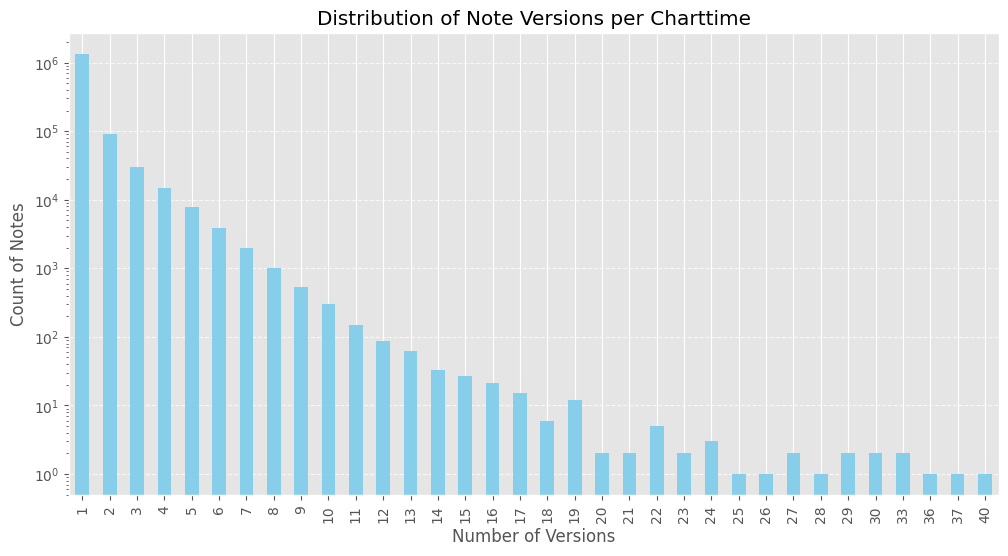


=== Breakdown by Note Category ===
                 total_versions              
                          count      mean max
category                                     
Nursing                   84465  2.625916  40
Physician                 62228  2.261120  17
Consult                      65  1.507692   6
Nutrition                  7295  1.287594  14
Social Work                2163  1.220065   7
General                    6994  1.171719  16
Rehab Services             4910  1.101018   5
Pharmacy                     91  1.098901   4
Radiology                497602  1.049592   4
Case Management             913  1.043812   3
Nursing/other            792048  1.038443  33
Respiratory               30681  1.032072   5


In [87]:
summary_stats = {
    "Total note groups": len(notes_df),
    "Notes with multiple versions": len(notes_df[notes_df['total_versions'] > 1]),
    "Maximum versions of a single note": notes_df['total_versions'].max(),
    "Average versions per note": round(notes_df['total_versions'].mean(), 2),
    "Notes with exact duplicates": len(notes_df[notes_df['exact_duplicates'] > 0]),
    "Notes with draft versions": len(notes_df[notes_df['potential_drafts'] > 0])
}

print("=== Duplicate Note Analysis ===")
for stat, value in summary_stats.items():
    print(f"{stat}: {value:,}")

# Plot distribution of note versions
plt.figure(figsize=(12, 6))
notes_df['total_versions'].value_counts().sort_index().plot(
    kind='bar',
    color='skyblue',
    title='Distribution of Note Versions per Charttime'
)
plt.xlabel('Number of Versions')
plt.ylabel('Count of Notes')
plt.yscale('log')  # Log scale for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Breakdown by note category
category_stats = notes_df.groupby('category').agg({
    'total_versions': ['count', 'mean', 'max']
}).sort_values(('total_versions', 'mean'), ascending=False)

print("\n=== Breakdown by Note Category ===")
print(category_stats.to_string())

5.4 does not include any results proving this idea, from what I saw - but this is very interesting!